### 作业内容
- 绘制一个网络的log binning图
- 绘制一个网络的cumulative图
- 采用最大似然方法拟合loglog图，log binning图，cumulative图

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

### 引入科学家合作网络数据

In [2]:
## 读取网络链接数据

edgelist = []
authors = []
papers = []
with open('./data/paperauthorID.txt', 'r') as fr:
    for line in fr:
        p,a = line.strip().split('\t')
        edgelist.append(('p'+p, 'a'+a))
        authors.append('a'+a)
        papers.append('p'+p)

B = nx.Graph()
B.add_edges_from(edgelist)


authors = list(set(authors))
print(len(authors))
print('节点数:',B.number_of_nodes())
print('边数:',B.number_of_edges())

1992
节点数: 4004
边数: 5240


In [3]:
## 将二分网映射为作者合作网

g = nx.algorithms.bipartite.projected_graph(B, nodes=authors)
print('节点数:',g.number_of_nodes())
print('边数:',g.number_of_edges())
print('平均度:',np.mean(list(dict(nx.degree(g)).values())))

节点数: 1992
边数: 3485
平均度: 3.498995983935743


### 简单的可视化

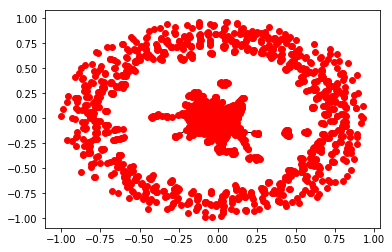

In [4]:
nx.draw_networkx(g,with_labels=False,node_size=35,edge_width=1000)
plt.show()

In [5]:
## degree of each nodes
deg_dist = nx.degree_histogram(g)

### 普通度分布

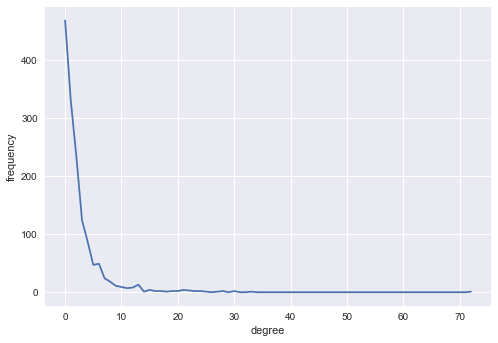

In [6]:
plt.style.use('seaborn')
plt.plot(deg_dist[2:])
plt.xlabel('degree')
plt.ylabel('frequency')
plt.show()

## loglog图

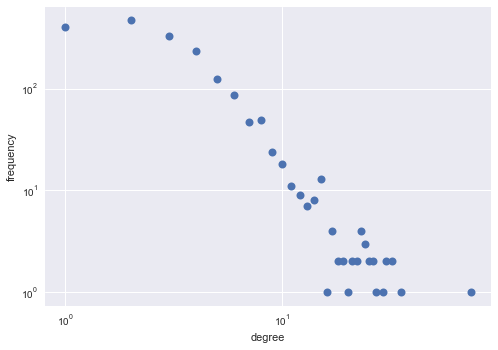

In [7]:
plt.style.use('seaborn')
author_deg = dict(g.degree()).values()
plt.loglog(range(0, len(deg_dist)), deg_dist, 'o',ms=8)
plt.xlabel('degree')
plt.ylabel('frequency')
plt.show()

分析：在双对数坐标下，原本难以发现规律的统计数据呈现直观的近似线性分布，但只有尾部呈现较好的线性分布特征，最尾端因为极端数据过多，统计规律并不明显

### log-binning 图

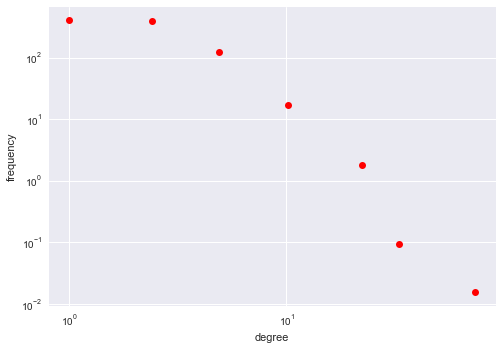

In [8]:
## 非等间距分箱

x = []
y = []

max_k = len(deg_dist)

k0 = 1
dk = 2
while k0<=len(deg_dist):
    # 每次binning扩大dk倍
    k1 = k0*dk
    # 一个binning内的和
    n=sum([deg_dist[k] for k in range(max_k) if k0<=k<k1])
    m = sum([k*deg_dist[k] for k in range(max_k) if k0<=k<k1])
    if n>0:
        x.append(1.0*m/n)
        # 每个binning除以其宽度进行归一化处理
        y.append(n/max(1,(k1-k0)))
    k0 = k1

plt.loglog(x,y,'ro')
plt.xlabel('degree')
plt.ylabel('frequency')
plt.legend()
plt.show()

分析：log-binning图很好的解决了数据尾端数据量极少而导致的统计规律不明显的情况

### 绘制一个网络的cumulative图

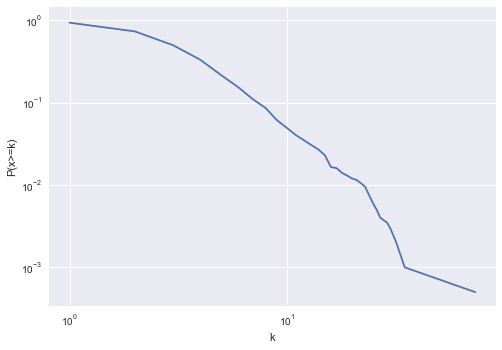

In [27]:
##累积分布
degree = list(dict(nx.degree(g)).values())
distKeys = set(degree)
pdf = dict([(k,0) for k in distKeys])
for k in degree:
    pdf[k] += 1

cdf = dict([(k,0) for k in set(degree)])
for k in set(degree):
    cdf[k] = sum(np.array(degree)>=k)
# plt.loglog(cdf.keys(), list(cdf.values()) / np.sum(list(cdf.values())))
plt.loglog(cdf.keys(), list(cdf.values()) / list(cdf.values())[0])
plt.xlabel('k')
plt.ylabel('P(x>=k)')
plt.legend()
plt.show()

In [24]:
cdf.values()

dict_values([1992, 1866, 1462, 994, 663, 430, 306, 219, 172, 123, 99, 81, 70, 61, 54, 46, 33, 32, 28, 26, 24, 23, 21, 19, 15, 12, 10, 8, 7, 6, 4, 2, 1])

累计分布函数是另一种观察幂律分布的很好的方法，其纵坐标pk指的是节点度数大于k的节点所占的比例。累计分布函数更容易体现幂律分布数据的特征，在双对数坐标下的线性关系更为明显。

### 利用极大似然拟合loglog图

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


-2.2607734484117734 7.9985678355094825


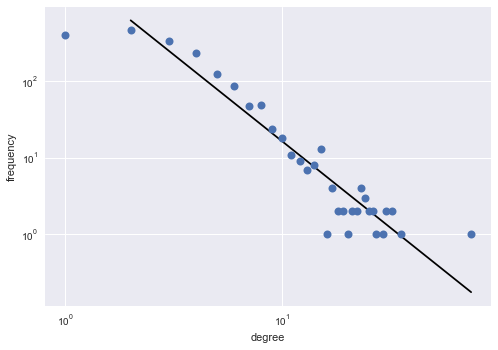

In [69]:
## degree of each nodes
deg_dist = nx.degree_histogram(g)
plt.style.use('seaborn')
author_deg = dict(g.degree()).values()



x = range(0,len(deg_dist))
y = deg_dist
xs = []
ys = []
for i in range(len(y)):
    if y[i] != 0:
        xs.append(i)
        ys.append(y[i])

ln_x = np.log(xs[2:])
ln_y = np.log(ys[2:])
A = np.vstack([ln_x, np.ones(len(ln_x))]).T
m,c = np.linalg.lstsq(A,ln_y)[0]
print(m,c)
plt.plot(np.e**ln_x,np.e**(m*ln_x+c), 'k-',label=r'$\gamma=%s$'%(round(-m,2)))


plt.loglog(x, y, 'o',ms=8)
plt.xlabel('degree')
plt.ylabel('frequency')
plt.show()

### 拟合log binning 图

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


-3.4505705066508954 10.569102897706035


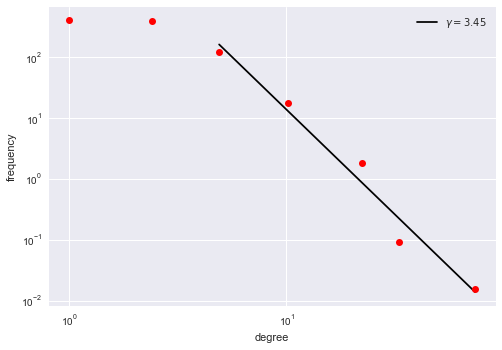

In [47]:
## 非等间距分箱

x = []
y = []

max_k = len(deg_dist)

k0 = 1
dk = 2
while k0<=len(deg_dist):
    # 每次binning扩大dk倍
    k1 = k0*dk
    # 一个binning内的和
    n=sum([deg_dist[k] for k in range(max_k) if k0<=k<k1])
    m = sum([k*deg_dist[k] for k in range(max_k) if k0<=k<k1])
    if n>0:
        x.append(1.0*m/n)
        # 每个binning除以其宽度进行归一化处理
        y.append(n/max(1,(k1-k0)))
    k0 = k1

ln_x = np.log(x[2:])
ln_y = np.log(y[2:])
A = np.vstack([ln_x, np.ones(len(ln_x))]).T
m,c = np.linalg.lstsq(A,ln_y)[0]
print(m,c)
plt.plot(np.e**ln_x,np.e**(m*ln_x+c), 'k-',label=r'$\gamma=%s$'%(round(-m,2)))


    
plt.loglog(x,y,'ro')
plt.xlabel('degree')
plt.ylabel('frequency')
plt.legend()
plt.show()

### 拟合累计分布

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  app.launch_new_instance()


-1.996701575587312 1.3655181051658691


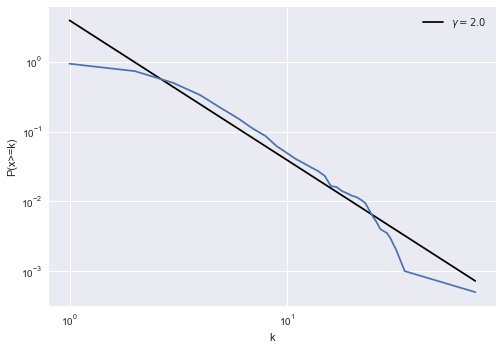

In [40]:
##累积分布
degree = list(dict(nx.degree(g)).values())
distKeys = set(degree)
pdf = dict([(k,0) for k in distKeys])
for k in degree:
    pdf[k] += 1

cdf = dict([(k,0) for k in set(degree)])
for k in set(degree):
    cdf[k] = sum(np.array(degree)>=k)

    
ln_x = np.log(list(cdf.keys())[1:])
ln_y = np.log(list(cdf.values())[1:]/list(cdf.values())[0])
A = np.vstack([ln_x, np.ones(len(ln_x))]).T
m,c = np.linalg.lstsq(A,ln_y)[0]
print(m,c)
plt.plot(np.e**ln_x,np.e**(m*ln_x+c), 'k-',label=r'$\gamma=%s$'%(round(-m,2)))




    
plt.loglog(cdf.keys(),  list(cdf.values()) / list(cdf.values())[0])
plt.xlabel('k')
plt.ylabel('P(x>=k)')
plt.legend()
plt.show()

In [39]:
ln_x

array([      -inf, 0.        , 0.69314718, 1.09861229, 1.38629436,
       1.60943791, 1.79175947, 1.94591015, 2.07944154, 2.19722458,
       2.30258509, 2.39789527, 2.48490665, 2.56494936, 2.63905733,
       2.7080502 , 2.77258872, 2.83321334, 2.89037176, 2.94443898,
       2.99573227, 3.04452244, 3.09104245, 3.13549422, 3.17805383,
       3.21887582, 3.25809654, 3.29583687, 3.36729583, 3.40119738,
       3.4657359 , 3.55534806, 4.30406509])